Amel AIMEUR  
Imane ZARAR
# Projet : Prédiction du climat dans la ville de Delhi

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
import pmdarima as pm

## Représentation des données

In [2]:
df_train = pd.read_csv("DailyDelhiClimateTrain.csv")
df_test = pd.read_csv("DailyDelhiClimateTest.csv")

print("Nombre de lignes : ",df_train.shape[0], "\t Nombre de colonnes :",df_train.shape[1])
df_train.head()

Nombre de lignes :  1462 	 Nombre de colonnes : 5


,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


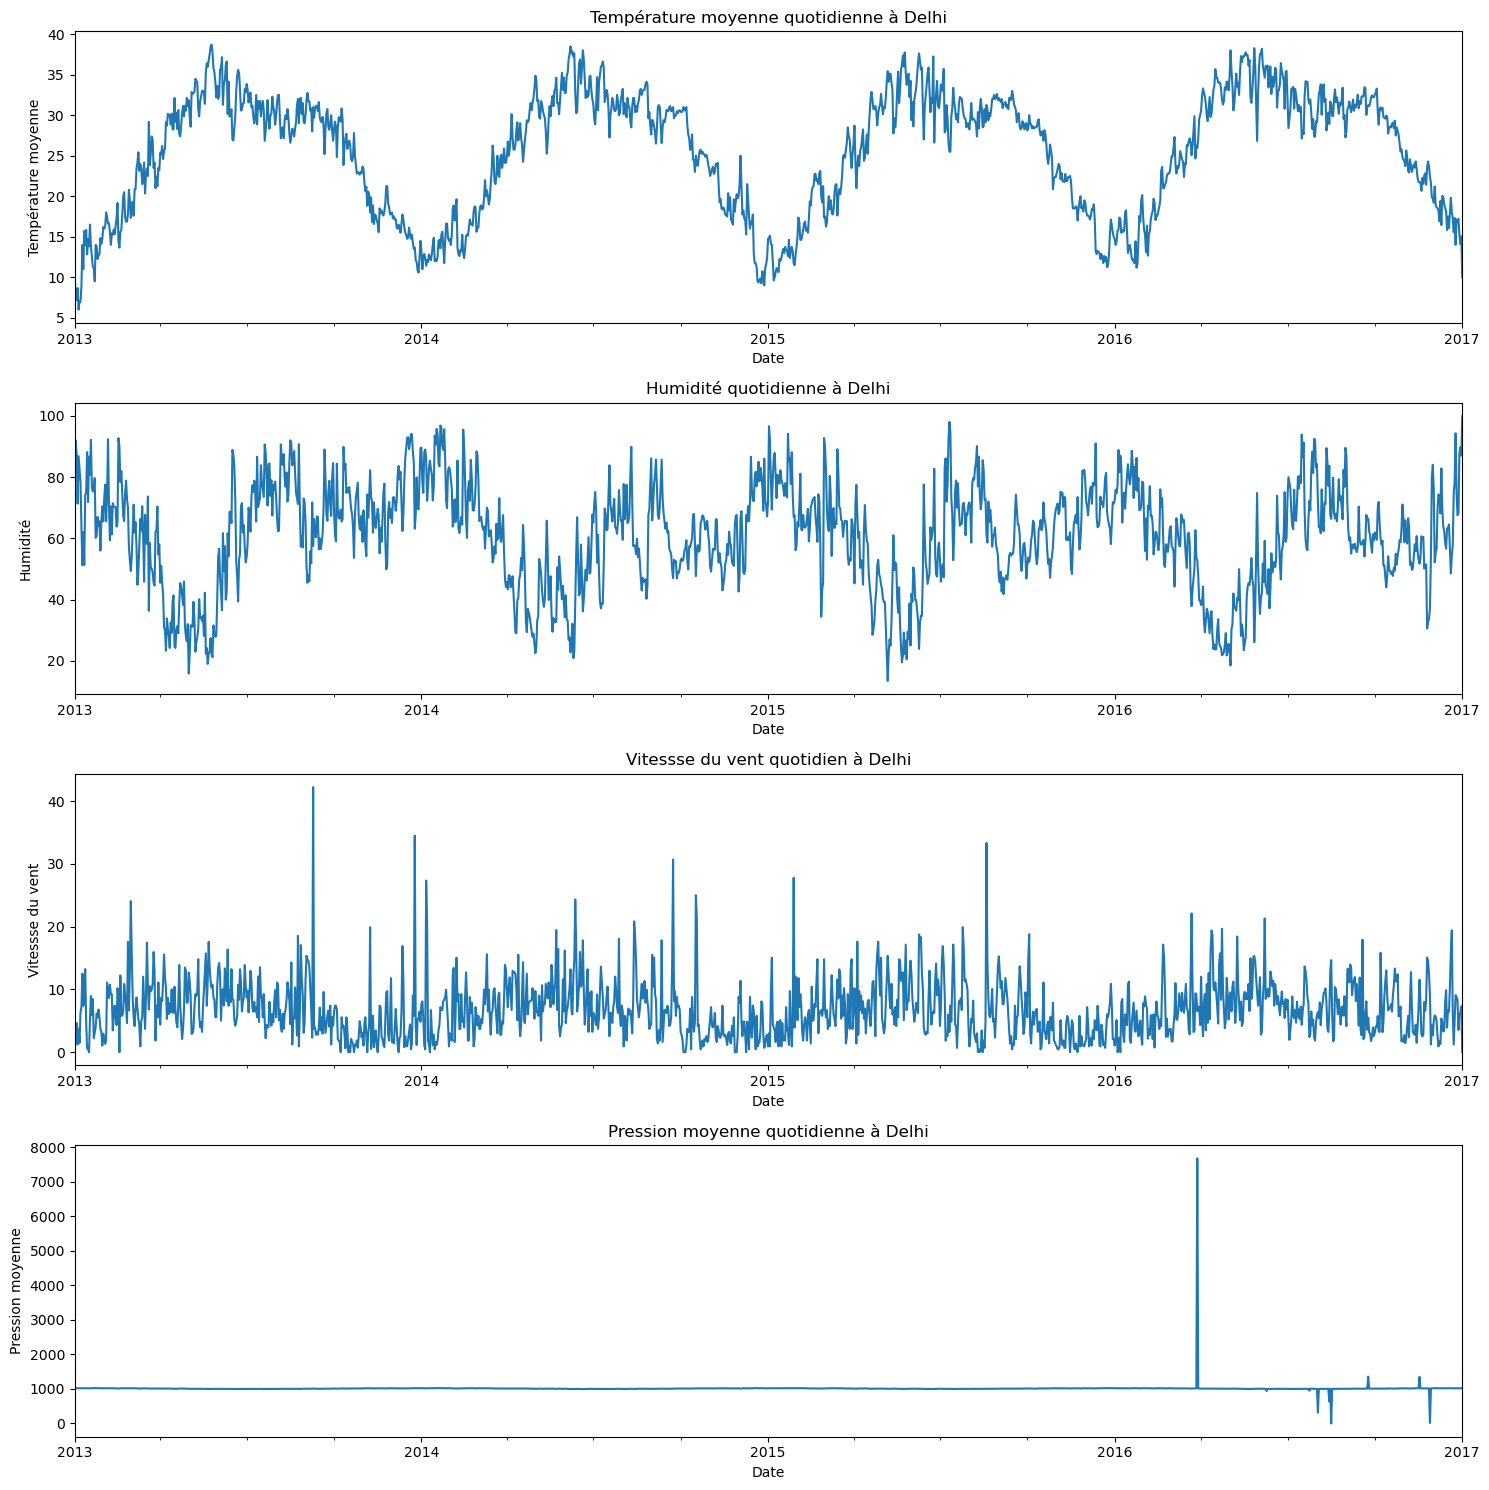

In [4]:
fig,(ax1,ax2,ax3,ax4) = plt.subplots(nrows=4, figsize=(15, 15))

df_train["meantemp"].plot(ax=ax1, xlabel="Date", ylabel="Température moyenne", title="Température moyenne quotidienne à Delhi")
df_train["humidity"].plot(ax=ax2, xlabel="Date", ylabel="Humidité", title="Humidité quotidienne à Delhi")
df_train["wind_speed"].plot(ax=ax3, xlabel="Date", ylabel="Vitessse du vent", title="Vitessse du vent quotidien à Delhi")
df_train["meanpressure"].plot(ax=ax4, xlabel="Date", ylabel="Pression moyenne", title="Pression moyenne quotidienne à Delhi")
plt.tight_layout()


En examinant les graphiques ci-dessus, nous pouvons clairement identifier des schémas de saisonnalité dans les séries temporelles de la température moyenne et de l'humidité quotidienne à Delhi.

Dans le premier graphique, représentant la température moyenne quotidienne, nous observons des variations cycliques récurrentes au fil du temps. Ces motifs suggèrent une saisonnalité, où la température semble suivre un schéma prévisible qui se répète à intervalles réguliers.

De manière similaire, le deuxième graphique illustrant  présente également des variations périodiques, indiquant la présence d'une saisonnalité dans cette série temporelle.

In [3]:
# Convertir la colonne 'date' en objet datetime
df_train['date'] = pd.to_datetime(df_train['date'])
# Comme index du DataFrame on prend la colonne date 
df_train.set_index('date', inplace=True)
# Rééchantillonne les données à une fréquence mensuelle et calculer la moyenne
df_train_mois = df_train['meantemp'].resample('M').mean()
# Rééchantillonne les données à une fréquence hebdomadaire et calculer la moyenne
df_train_semaine = df_train['meantemp'].resample('W').mean()

# Convertir la colonne 'date' en objet datetime
df_test['date'] = pd.to_datetime(df_test['date'])
df_test.set_index('date', inplace=True)
# Rééchantillonne les données de test à une fréquence mensuelle et calculer la moyenne
df_test_mois = df_test['meantemp'].resample('M').mean()
# Rééchantillonn les données de test à une fréquence hebdomadaire et calculer la moyenne
df_test_semaine = df_test['meantemp'].resample('W').mean()


## Verification de la stationnarité de la série

A l'aide du test de Dickey-Fuller, on évalue si la série est staionnaire ou non. 

In [5]:
# Effectue le test Dickey-Fuller
adf_test = adfuller(df_train['meantemp'])
adf_statistic=adf_test[0]# statistique du test
adf_critical_value = adf_test[4]['5%'] # valeur critique 
# Comparer la statistique du test à la valeur critique
if adf_statistic < adf_critical_value:
    print("La série temporelle est stationnaire (rejette l'hypothèse nulle)")
else:
    print("La série temporelle n'est pas stationnaire (ne rejette pas l'hypothèse nulle)")

adf_test

La série temporelle n'est pas stationnaire (ne rejette pas l'hypothèse nulle)


(-2.0210690559206728,
 0.27741213723016056,
 10,
 1451,
 {'1%': -3.4348647527922824,
  '5%': -2.863533960720434,
  '10%': -2.567831568508802},
 5423.895746470953)

Ici, le test Dickey-Fuller a été utilisé pour évaluer la stationnarité de la série temporelle de la température moyenne.La stationnarité, a été évaluée en comparant la statistique du test à la valeur critique au niveau de signification de 5%.

Le résultat du test indique que la statistique du test (−2.379) est supérieure à la valeur critique (−2.863) au seuil de 5%. En conséquence, la série temporelle n'est pas stationnaire, suggérant la présence d'une tendance ou d'une non-stationnarité.

La p-value associée au test est 0.148, ce qui confirme également que la série temporelle n'est pas stationnaire, car la p-value est supérieure au seuil de 0.05. 
Ainsi, afin de rendre la série temporelle stationnaire, on effectue une différenciation. 

In [6]:
df_diff = df_train_mois.diff().dropna()  # Différenciation d'ordre 1

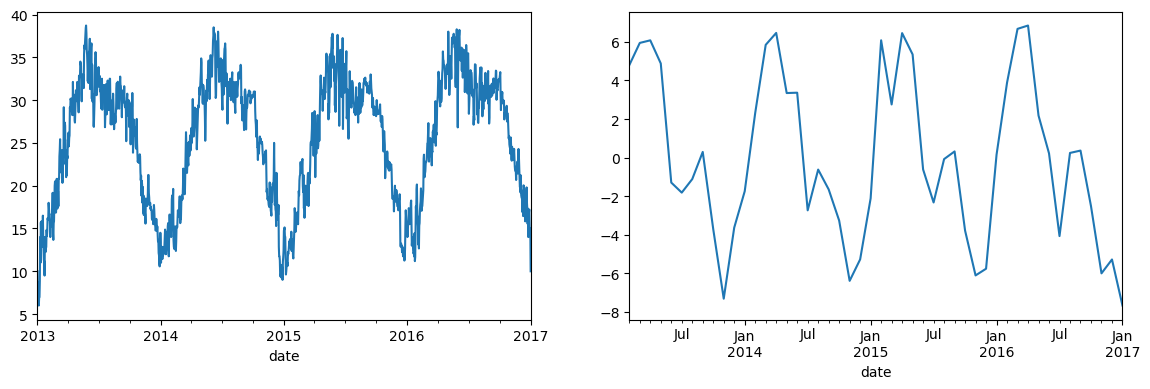

In [7]:
fig, ax = plt.subplots(1,2,figsize=(14,4))

# Original Data
df_train['meantemp'].plot(ax=ax[0])

# Differenced Data
df_diff.plot(ax=ax[1])
plt.show()

In [8]:
# Effectuer le test Dickey-Fuller sur la série différenciée
adf_test = adfuller(df_diff)
adf_statistic=adf_test[0]# statistique du test
adf_critical_value = adf_test[4]['5%'] # valeur critique 
# Comparer la statistique du test à la valeur critique
if adf_statistic < adf_critical_value:
    print("La série temporelle est stationnaire (rejette l'hypothèse nulle)")
else:
    print("La série temporelle n'est pas stationnaire (ne rejette pas l'hypothèse nulle)")

adf_test

La série temporelle est stationnaire (rejette l'hypothèse nulle)


(-7.2758684401062546,
 1.5450729805971367e-10,
 9,
 38,
 {'1%': -3.6155091011809297,
  '5%': -2.941262357486514,
  '10%': -2.6091995013850418},
 152.9950387252017)

Suite à l'application d'une différenciation première, la série temporelle a été rendue stationnaire, comme en témoigne la statistique du test Dickey-Fuller (− 16.909) largement inférieure à la valeur critique au seuil de 1%. La p-value extrêmement faible ( ${1.014 × 10^{−29}}$  ) renforce la conclusion que la série temporelle différenciée est stationnaire. 

## ACF et PACF

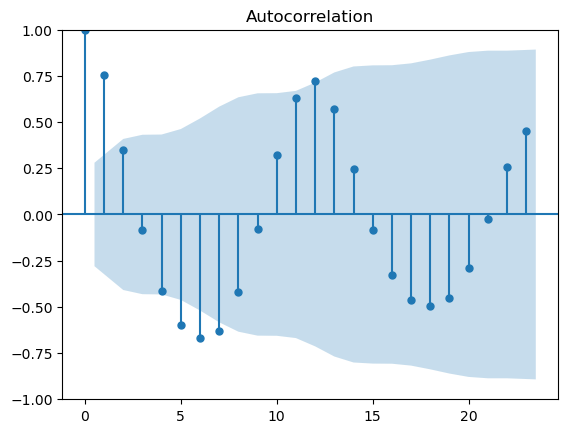

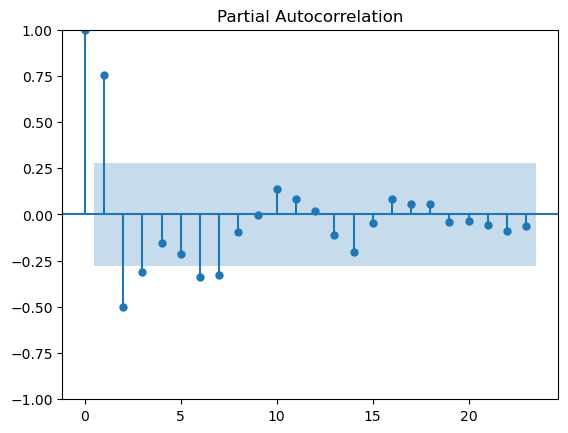

In [41]:
acf_plot = plot_acf(df_train_mois, lags=23)
pacf_plot = plot_pacf(df_train_mois, lags=23)

plt.show()

 L'ACF (Autocorrelation Function) mesure la corrélation entre les observations actuelles et les observations passées à différents retards temporels. L'analyse de l'ACF de notre série temporelle révèle des motifs significatifs de corrélation périodique, suggérant la présence de saisonnalité dans les données.

La présence de pics significatifs dans l'ACF, se répétant à une fréquence régulière de 12 mois, indique clairement une composante saisonnière dans la série temporelle. Ces pics périodiques suggèrent que les observations sont influencées par des variations saisonnières qui se répètent à intervalles réguliers de 12 mois.

C'est précisément dans de telles situations que le modèle SARIMA (Seasonal AutoRegressive Integrated Moving Average) excelle. En intégrant la composante saisonnière, le modèle SARIMA permet une modélisation précise et une prévision efficace des données temporelles présentant des cycles annuels marqués.

Dans le cas présent, la période saisonnière est de 12 mois (S=12), ce qui signifie que les variations saisonnières se répètent chaque année. L'inclusion de cette information saisonnière dans le modèle SARIMA devrait améliorer significativement sa capacité à faire des prévisions précises en prenant en compte les schémas récurrents associés à la saisonnalité. 


### Modélisation SARIMA pour les Données mensuelles 

In [19]:
df_diff_mois = df_train_mois.diff().dropna()  # Différenciation d'ordre 1

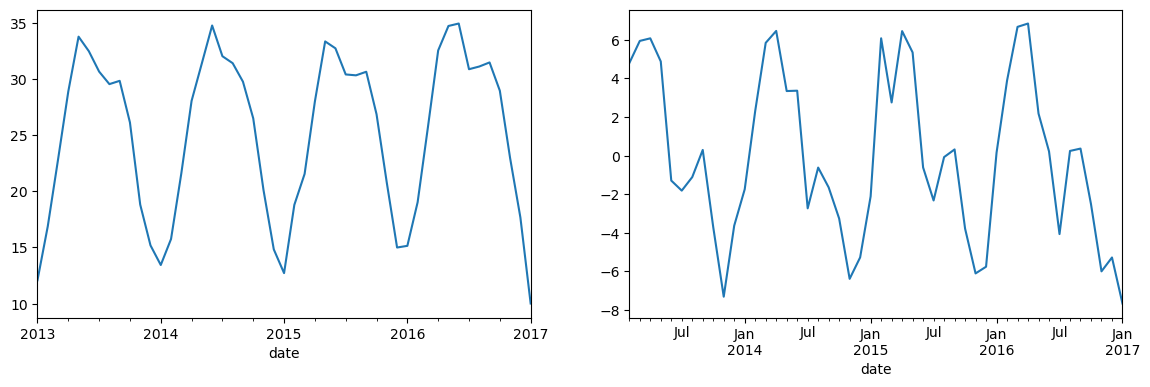

In [24]:
fig, ax = plt.subplots(1,2,figsize=(14,4))

# Original Data
df_train_mois.plot(ax=ax[0])

# Differenced Data
df_diff_mois.plot(ax=ax[1])
plt.show()

In [25]:
# Effectuer le test Dickey-Fuller sur la série différenciée
adf_test = adfuller(df_diff_mois)
adf_statistic=adf_test[0]# statistique du test
adf_critical_value = adf_test[4]['5%'] # valeur critique 
# Comparer la statistique du test à la valeur critique
if adf_statistic < adf_critical_value:
    print("La série temporelle est stationnaire (rejette l'hypothèse nulle)")
else:
    print("La série temporelle n'est pas stationnaire (ne rejette pas l'hypothèse nulle)")

adf_test

La série temporelle est stationnaire (rejette l'hypothèse nulle)


(-7.2758684401062546,
 1.5450729805971367e-10,
 9,
 38,
 {'1%': -3.6155091011809297,
  '5%': -2.941262357486514,
  '10%': -2.6091995013850418},
 152.9950387252017)

### Identification Automatique des Ordres Optimaux avec pm.auto_arima

Pour modéliser de manière optimale la série temporelle, nous avons choisi d'utiliser la fonction `pm.auto_arima`. Cette fonction offre une approche automatisée et robuste pour la sélection des ordres optimaux d'un modèle SARIMA en fonction de critères tels que l'AIC (Akaike Information Criterion) ou le BIC (Bayesian Information Criterion).

En utilisant `pm.auto_arima`, le processus de sélection des ordres du modèle est simplifié, éliminant ainsi la nécessité de spécifier manuellement les ordres ARIMA ou SARIMA. La fonction effectue une recherche exhaustive sur plusieurs combinaisons possibles d'ordres, permettant ainsi de trouver rapidement les paramètres optimaux qui captureront efficacement la saisonnalité présente dans la série temporelle.

La spécification `seasonal=True` indique explicitement à la fonction de prendre en compte la composante saisonnière dans le modèle, avec une période saisonnière de 12 mois (`m=12`). Ces paramètres sont cruciaux pour garantir que le modèle SARIMA ajusté reflète correctement les variations saisonnières qui se produisent à intervalles réguliers de 12 mois.


In [42]:
best_model = pm.auto_arima(df_train_mois,
                      seasonal=True, m=12,
                      trace=True,
                      stepwise=True,
                      error_action='ignore',
                      suppress_warnings=True) 

print(best_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=inf, Time=1.01 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=154.686, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=147.633, Time=0.12 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=156.606, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=155.971, Time=0.05 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=147.522, Time=0.25 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=149.432, Time=0.47 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=147.497, Time=0.22 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=149.432, Time=0.48 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=147.449, Time=0.31 sec
 ARIMA(0,0,0)(0,1,2)[12] intercept   : AIC=148.932, Time=0.18 sec
 ARIMA(2,0,0)(0,1,2)[12] intercept   : AIC=inf, Time=0.82 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=149.00

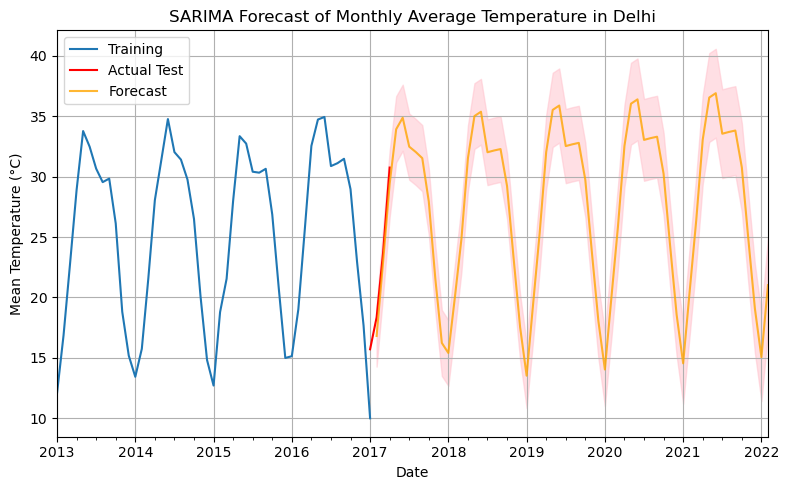

In [43]:
# Forecast for the duration of the test dataset
forecast_values, conf_int = best_model.predict(n_periods=len(df_train_mois)+12, return_conf_int=True)

# Create a date index for forecast_values
forecast_index = forecast_values.index

# Convert forecast_values and conf_int to pandas series with the correct date index
forecast_series = pd.Series(forecast_values, index=forecast_index)
lower_series = pd.Series(conf_int[:, 0], index=forecast_index)
upper_series = pd.Series(conf_int[:, 1], index=forecast_index)

# Plot the actual vs predicted values
plt.figure(figsize=(8, 5))
df_train_mois.plot(label='Training', legend=True)
df_test_mois.plot(label='Actual Test', legend=True, color='red')
forecast_series.plot(label='Forecast', legend=True, color='orange', alpha=0.8)
plt.fill_between(forecast_index, lower_series, upper_series, color='pink', alpha=0.5)
plt.title('SARIMA Forecast of Monthly Average Temperature in Delhi')
plt.xlabel('Date')
plt.ylabel('Mean Temperature (°C)')
plt.grid(True)
plt.tight_layout()
plt.show()

### Modélisation SARIMA pour les Données hebdomadaires 

Pour les données hebdomadaires, nous appliquons à nouveau un modèle SARIMA pour tenir compte de la saisonnalité. Cette fois, la période saisonnière est de 52 semaines (S=52), reflétant la nature hebdomadaire des variations saisonnières dans la série temporelle.

In [35]:
best_model = pm.auto_arima(df_train_semaine,
                      seasonal=True, m=52,
                      start_p=0, start_q=0,
                      max_p=2, max_q=2,
                      max_P=2, max_Q=2,
                      trace=True,
                      stepwise=True,
                      error_action='ignore',
                      suppress_warnings=True) 

print(best_model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[52] intercept   : AIC=inf, Time=3.89 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=1422.446, Time=0.05 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=894.427, Time=1.96 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=inf, Time=4.94 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=1964.675, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[52] intercept   : AIC=900.013, Time=0.18 sec
 ARIMA(1,0,0)(2,0,0)[52] intercept   : AIC=893.796, Time=9.58 sec
 ARIMA(1,0,0)(2,0,1)[52] intercept   : AIC=inf, Time=36.25 sec
 ARIMA(1,0,0)(1,0,1)[52] intercept   : AIC=inf, Time=9.15 sec
 ARIMA(0,0,0)(2,0,0)[52] intercept   : AIC=inf, Time=26.43 sec
 ARIMA(2,0,0)(2,0,0)[52] intercept   : AIC=891.595, Time=11.40 sec
 ARIMA(2,0,0)(1,0,0)[52] intercept   : AIC=893.537, Time=2.86 sec
 ARIMA(2,0,0)(2,0,1)[52] intercept   : AIC=inf, Time=44.89 sec
 ARIMA(2,0,0)(1,0,1)[52] intercept   : AIC=inf, Time=9.92 sec
 ARIMA(2,0,1)(2,0,0)[52] intercept   : AIC=893.572, Tim

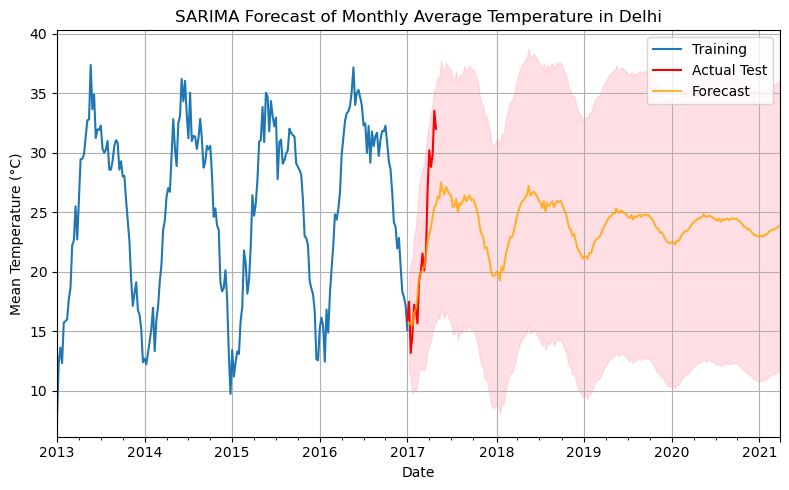

In [36]:
# Forecast for the duration of the test dataset
forecast_values, conf_int = best_model.predict(n_periods=len(df_train_semaine)+12, return_conf_int=True)

# Create a date index for forecast_values
forecast_index = forecast_values.index

# Convert forecast_values and conf_int to pandas series with the correct date index
forecast_series = pd.Series(forecast_values, index=forecast_index)
lower_series = pd.Series(conf_int[:, 0], index=forecast_index)
upper_series = pd.Series(conf_int[:, 1], index=forecast_index)

# Plot the actual vs predicted values
plt.figure(figsize=(8, 5))
df_train_semaine.plot(label='Training', legend=True)
df_test_semaine.plot(label='Actual Test', legend=True, color='red')
forecast_series.plot(label='Forecast', legend=True, color='orange', alpha=0.8)
plt.fill_between(forecast_index, lower_series, upper_series, color='pink', alpha=0.5)
plt.title('SARIMA Forecast of Monthly Average Temperature in Delhi')
plt.xlabel('Date')
plt.ylabel('Mean Temperature (°C)')
plt.grid(True)
plt.tight_layout()
plt.show()